In [1]:
from data_preparation import DataPreparator
from apply_clustering import ClusteringApplier

In [2]:
from gradient_solver import *

In [3]:
import os.path
from itertools import chain, combinations
from typing import Dict, List, Tuple

import numpy as np
import pandas as pd
from gapstatistics.gapstatistics import GapStatistics
from clustering import AgglomerativeClusteringWrapper as AgglomerativeClustering
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform
from scipy.spatial.distance import jensenshannon, correlation, euclidean
from tqdm.contrib.concurrent import thread_map

import config

In [4]:
df_observable = pd.read_excel('../data/biological_set_raw_data.xlsx')
df_explainable = pd.read_excel('../data/biological_set_explaining_features.xlsx')

  0%|          | 0/1023 [00:00<?, ?it/s]

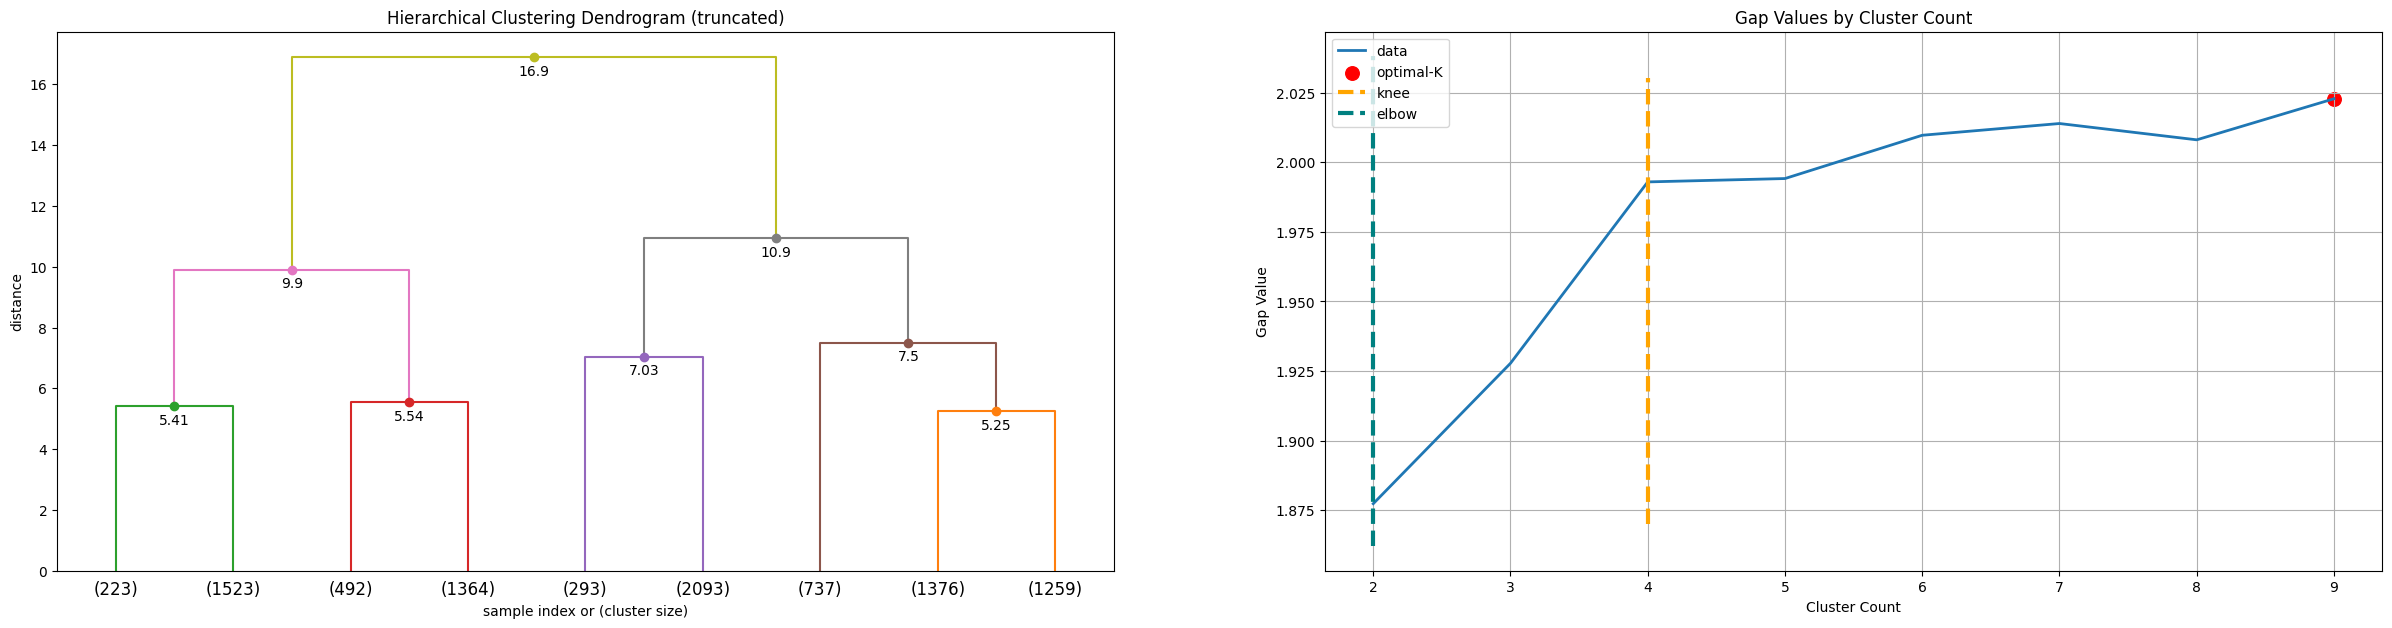

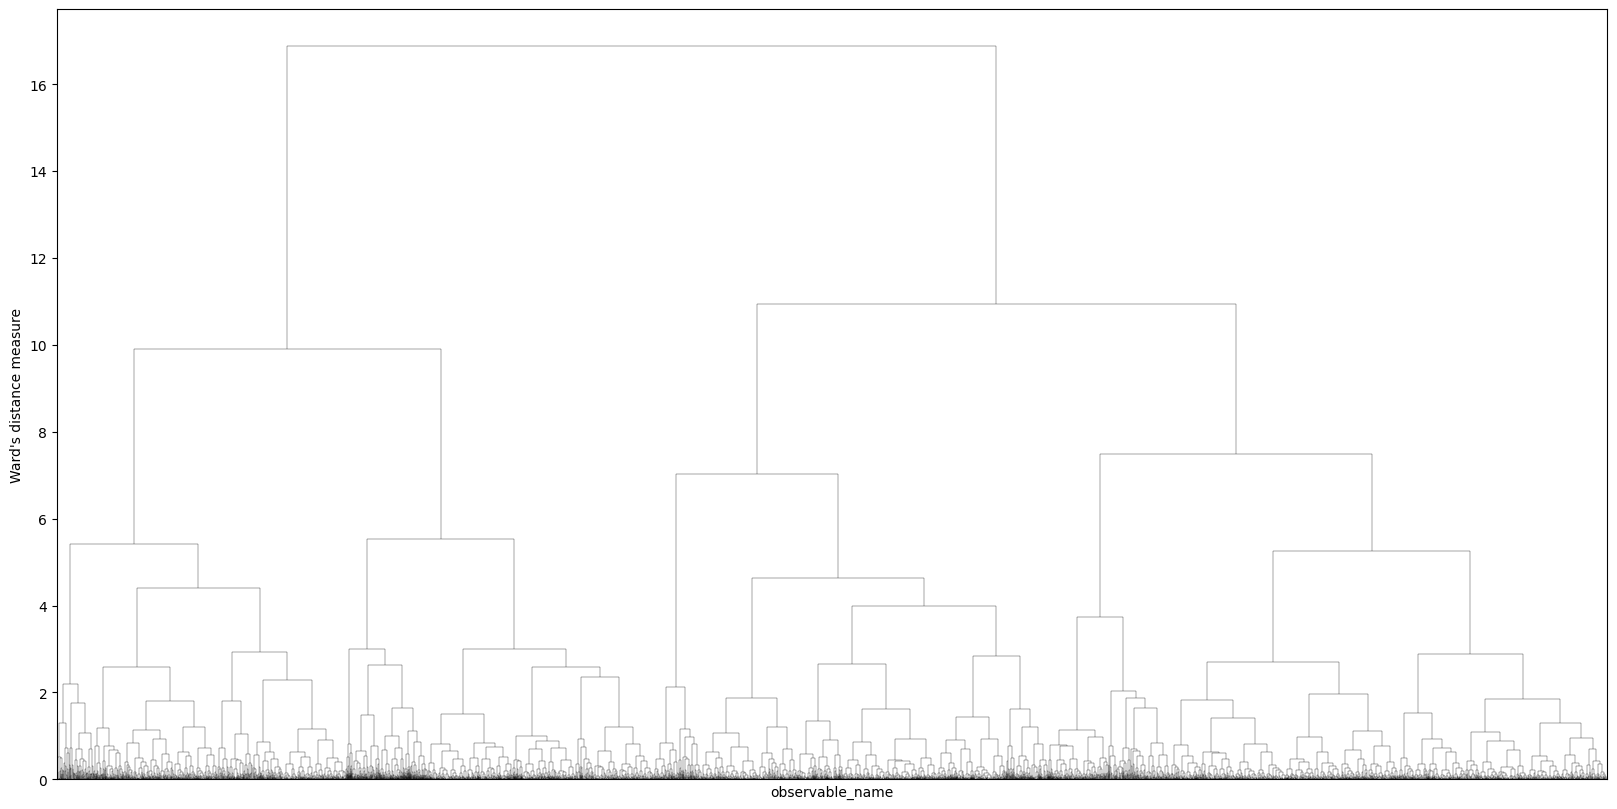

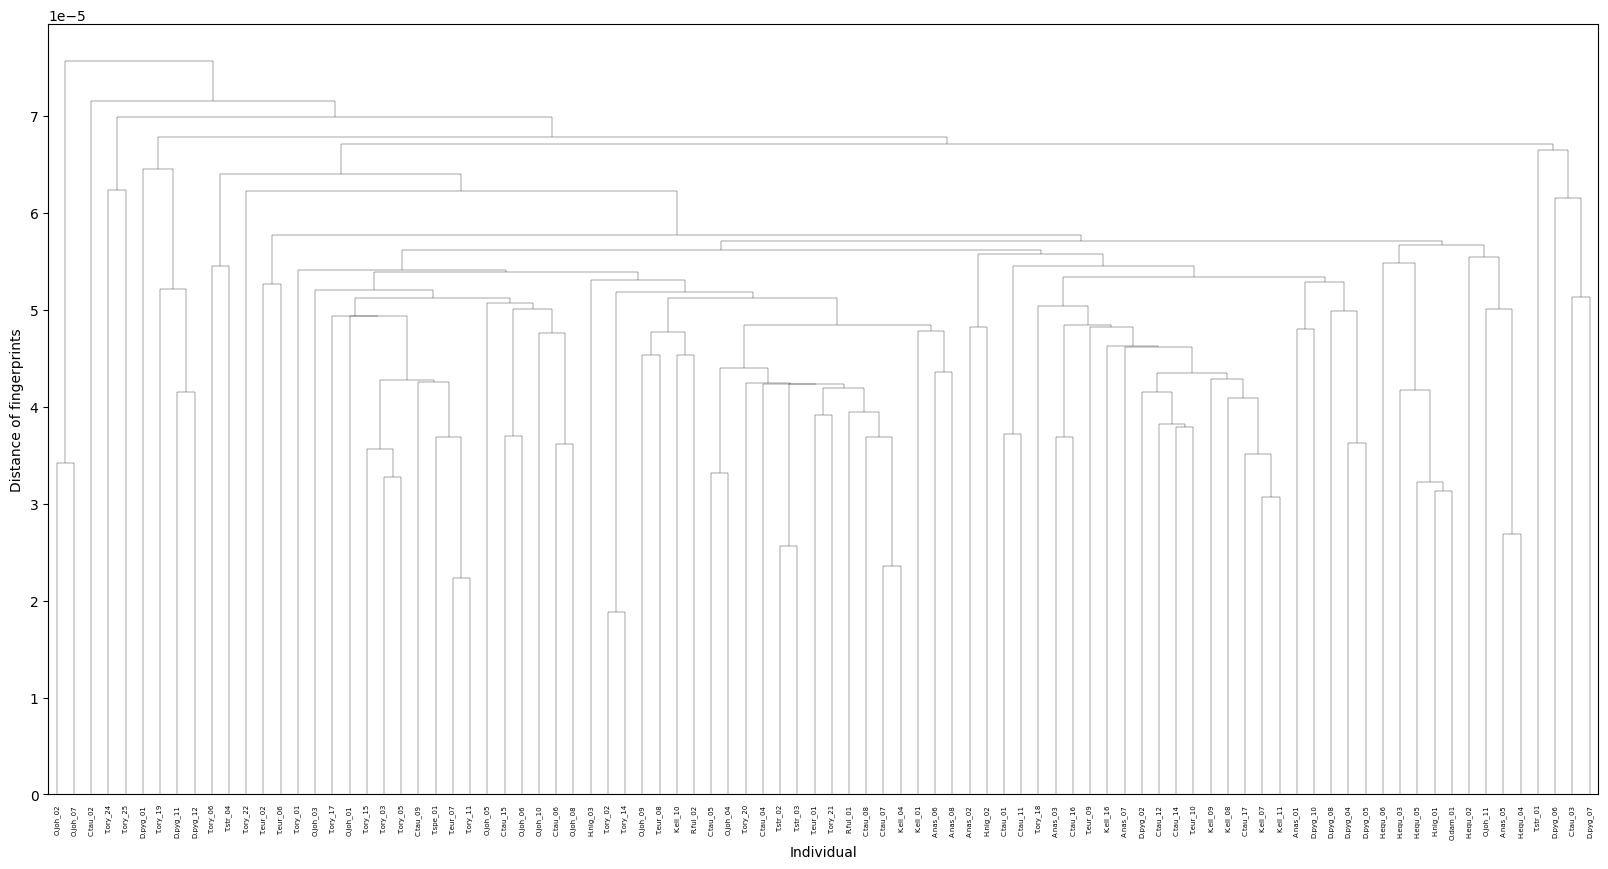

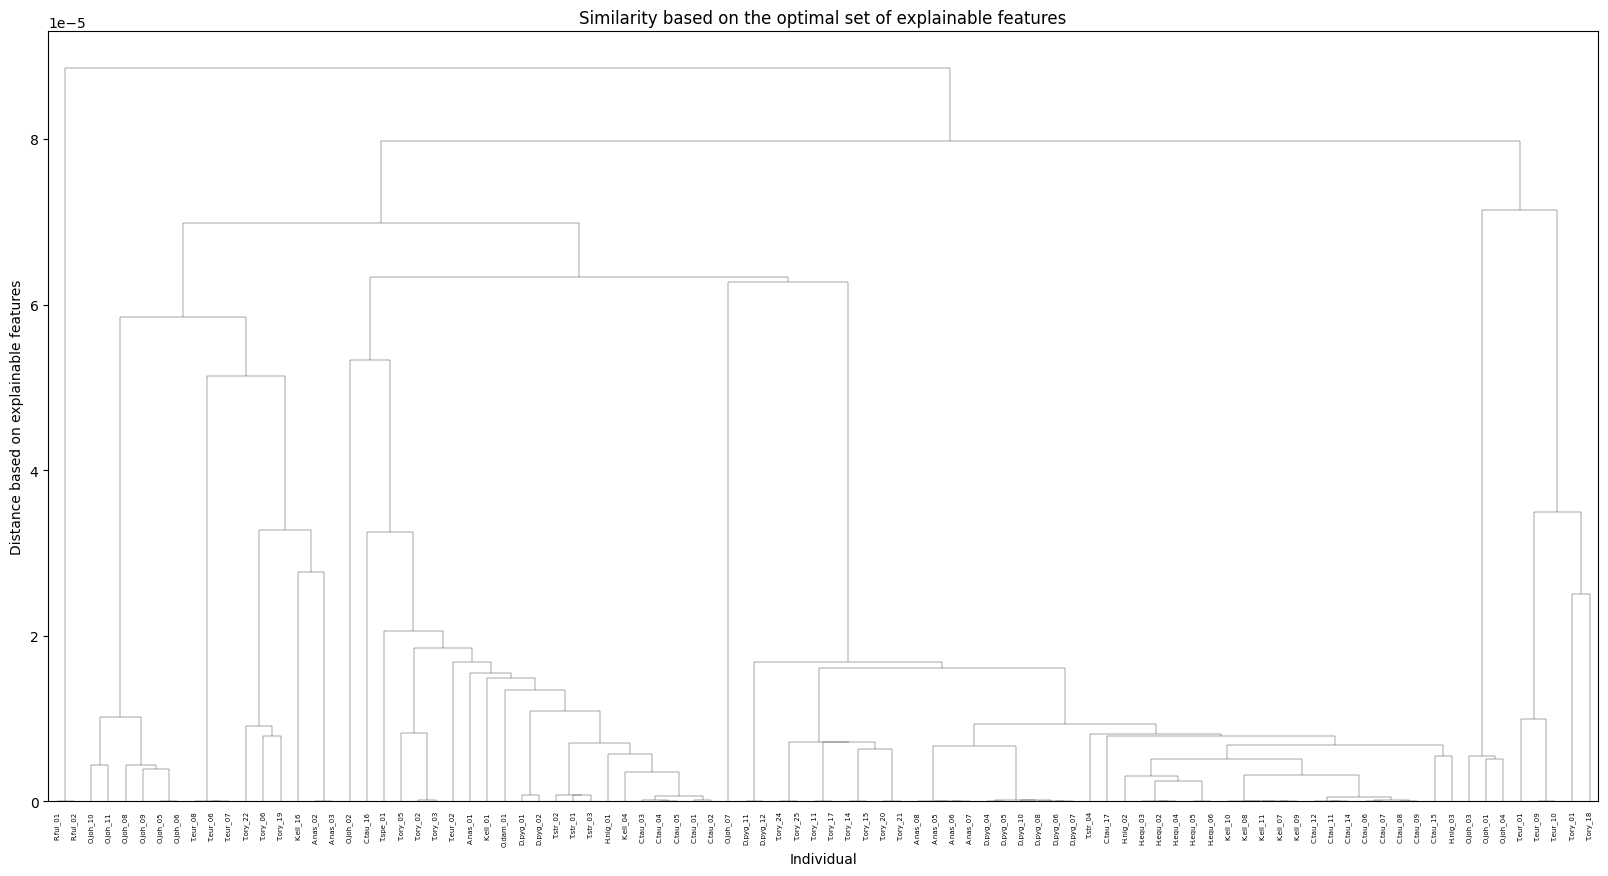

In [5]:
observed_features = ['perc_lying', 'perc_lhd', 'num_lying', 'num_lhd']
explaining_features = ['Age', 'Sex', 'Zoo', 'Stable', 'Genus_ID', 'Family_ID','Order_ID', 'SH', 'Weight', 'Habitat']
index_name = 'Individual'

preparation_result = DataPreparator.prepare_data(
    use_config=False,
    df_observable=df_observable,
    df_explainable=df_explainable,
    distortion_mean=0.,
    distortion_std=0.001,
    observed_features=observed_features,
    explaining_features=explaining_features,
    nn_imputation_k=10,
    group_name=index_name
)

optimal_number_of_clusters = ClusteringApplier.draw_gap_statistic_plot(
    use_config=False, df_observable=preparation_result['observable_df'],
    observed_features=observed_features,
    gap_statistic_cluster_range=10
)

observable_patterns_result = ClusteringApplier.calculate_observable_patterns(
    use_config=False,
    df_observable_data=preparation_result['observable_df'],
    _n_clusters=optimal_number_of_clusters['n_clusters'],
    observable_name='observable_name',
    observable_feature_names=observed_features,
    plot_title='Name of the plot',
    number_observable_patterns='auto',
    distance_measure_fingerprint='jensenshannon',
    group_name=index_name, 
)

calculate_explainable_distances_result = ClusteringApplier.calculate_explainable_distances(
    use_config=False,
    df_explainable=preparation_result['explainable_df'].copy(),
    df_observable_distances=observable_patterns_result['pw_norm_dist'].copy(),
    explaining_features=explaining_features,
    method='exact',
    distance_measure='correlation',
    sparsity_parameter=0.01,
    max_num_threads=12,
    group_name=index_name
)

In [7]:
observable_patterns_result['hom_df']

Individual,A.nas_01,A.nas_02,A.nas_03,A.nas_05,A.nas_06,A.nas_07,A.nas_08,C.tau_01,C.tau_02,C.tau_03,...,T.ory_20,T.ory_21,T.ory_22,T.ory_24,T.ory_25,T.spe_01,T.str_01,T.str_02,T.str_03,T.str_04
0,0.270332,0.192799,0.420762,0.547191,0.495205,0.438189,0.520328,0.288898,0.548544,0.709781,...,0.264665,0.35108,0.238682,0.772257,0.638513,0.843167,0.351895,0.439607,0.389341,0.5431


In [9]:
observable_patterns_result['df_fingerprint'].loc[:, 'Homogeneity'] = observable_patterns_result['hom_df'].T

In [10]:
observable_patterns_result['df_fingerprint']

,0,1,2,3,4,5,6,7,8,Homogeneity
Individual,,,,,,,,,,
A.nas_01,0.064516,0.000000,0.338710,0.241935,0.032258,0.000000,0.080645,0.016129,0.225806,0.270332
A.nas_02,0.032258,0.080645,0.338710,0.080645,0.064516,0.032258,0.016129,0.064516,0.290323,0.192799
A.nas_03,0.000000,0.031746,0.555556,0.206349,0.000000,0.000000,0.111111,0.079365,0.015873,0.420762
A.nas_05,0.000000,0.000000,0.272727,0.545455,0.000000,0.000000,0.000000,0.000000,0.181818,0.547191
A.nas_06,0.028571,0.000000,0.028571,0.085714,0.542857,0.000000,0.000000,0.000000,0.314286,0.495205
...,...,...,...,...,...,...,...,...,...,...
T.spe_01,0.916667,0.041667,0.000000,0.041667,0.000000,0.000000,0.000000,0.000000,0.000000,0.843167
T.str_01,0.034884,0.430233,0.058140,0.000000,0.034884,0.000000,0.255814,0.000000,0.186047,0.351895
T.str_02,0.382353,0.147059,0.000000,0.000000,0.382353,0.000000,0.000000,0.000000,0.088235,0.439607


In [6]:
from utils import minmax, calculate_homogeneity

In [7]:
df_fingerprint = observable_patterns_result['df_fingerprint']
df_fingerprint.shape

(90, 5)

In [8]:
df_explainable = preparation_result['explainable_df']

In [9]:
hom =calculate_homogeneity(df_fingerprint)

In [10]:
hom_df = pd.DataFrame(hom, index = df_fingerprint.index).T
hom_df

Individual,A.nas_01,A.nas_02,A.nas_03,A.nas_05,A.nas_06,A.nas_07,A.nas_08,C.tau_01,C.tau_02,C.tau_03,...,T.ory_20,T.ory_21,T.ory_22,T.ory_24,T.ory_25,T.spe_01,T.str_01,T.str_02,T.str_03,T.str_04
0,0.438056,0.146182,0.435211,0.430568,0.446511,0.307405,0.539432,0.227126,0.688978,0.465219,...,0.249451,0.498001,0.214467,1.0,0.578792,0.526478,0.506556,0.640666,0.528462,0.553458


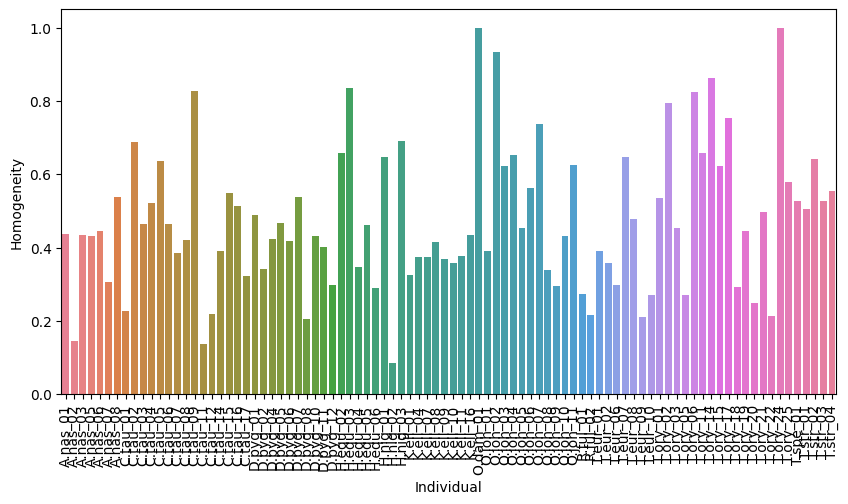

In [11]:
fig = plt.figure(figsize=(10, 5))
ax = sns.barplot(hom_df)
ax.axes.set_ylabel('Homogeneity')
ax.axes.xaxis.set_tick_params(rotation=90)

In [12]:
from visualize_result import ResultVisualizer
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from utils import minmax

In [13]:
def plot_result_radar_chart(
        simplex_coordinates_fingerprint: pd.DataFrame,
        categories_fingerprint: List[str],
        simplex_coordinates_explainable: pd.DataFrame,
        categories_explainable: List[str],
        title: str,
    ):

    assert simplex_coordinates_fingerprint.shape[0] == simplex_coordinates_explainable.shape[0], \
    'Error: Expected the same number of rows in simplex_coordinates_fingerprint and simplex_coordinates_explainable'   

    num_rows=simplex_coordinates_fingerprint.shape[0]
    num_cols=2
    plot_range = [0,1]

    row_titles = list(simplex_coordinates_explainable.index)

    fig = make_subplots(
            rows=num_rows,
            cols=num_cols,
            specs=[[{'type': 'polar', 'l':0.1}]*(num_cols)]*num_rows,
            horizontal_spacing=0.3, vertical_spacing=(0.05 / (num_rows - 1)),
            column_titles=["observable patterns", "explainable features"],
        )
    
    for i in range(num_rows):

        fig.add_scatterpolar(
            r=simplex_coordinates_fingerprint.iloc[i],
            theta=categories_fingerprint,
            fill="toself",
            row=i+1,
            col=1,    
        )

        fig.add_annotation(
            dict(
            x= 0.5,
            y = 1 - ((i+0.9) / num_rows),
            text=row_titles[i],
            showarrow=False,
            xref="paper",
            yref="paper",
            font=dict(size=14, color="black"),
            align="center"
        ))

        fig.add_scatterpolar(
            r=simplex_coordinates_explainable.iloc[i],
            theta=categories_explainable,
            fill="toself",
            row=i+1,
            col=2,
        )

    fig.update_layout(
        polar=dict(radialaxis=dict(visible=True, range=[0, 1])),
        showlegend=False,
        plot_bgcolor="rgba(0, 0, 0, 0)",
        paper_bgcolor="rgba(0, 0, 0, 0)",
        title=dict(
            text=title,
            automargin=True,
            xref='paper'
        ),
        margin=dict(
            t=50,  # Top margin
            b=50,  # Bottom margin
            l=50,  # Left margin
            r=50   # Right margin
        ),
        height=300*num_rows,
        width=600
    )

    fig.update_polars(
        dict(
            radialaxis=dict(
                visible=True,
                range=plot_range,
                showticklabels=False)
            )
    )

    '''output_path = f"{config.OUTPUT_FOLDER_BASE}result_visualization/"
    if not os.path.exists(output_path):
        os.makedirs(output_path)

    fig.write_image(
        f"{output_path}{config.DATASET_NAME}-{title}-radar_plot-{config.NUMBER_OBSERVABLE_PATTERNS}.pdf",
    )'''

    return fig

In [14]:
# Ensure that both datasets contain the same indices
valid_indices = np.intersect1d(df_explainable.index, df_fingerprint.index)
valid_indices.sort()
df_explainable = df_explainable.loc[valid_indices]
df_fingerprint = df_fingerprint.loc[valid_indices]

TypeError: '<' not supported between instances of 'str' and 'int'

In [ ]:
df_explainable

,Individual,Age,Sex,Zoo,Stable,Genus_ID,Family_ID,Order_ID,SH,Weight,Habitat,Feeding type
0,T.str_01,0.999940,0.002111,0.498371,0.998564,0.640138,0.997644,0.999593,0.854520,0.429926,0.333424,0
1,T.str_02,0.999653,-0.000044,0.599862,1.000976,0.640389,1.000413,0.999470,0.852993,0.431136,0.333833,0
2,T.str_03,0.999977,-0.000510,0.401913,0.999875,0.639268,0.999897,0.999916,0.853485,0.429005,0.332491,0
3,T.str_04,0.999719,1.001378,0.400170,1.000794,0.638673,0.999972,0.998830,0.856411,0.429108,0.334171,0
4,T.str_05,0.666615,0.999747,0.400106,1.001335,0.640351,1.001360,0.999426,0.855694,0.431574,0.331284,0
...,...,...,...,...,...,...,...,...,...,...,...,...
138,O.joh_07,1.000338,1.000755,0.999469,0.999499,0.058439,0.500855,0.999720,0.986752,0.422631,-0.000850,0
139,O.joh_08,0.998709,0.997716,0.149262,0.000630,0.057766,0.500683,1.001977,0.986642,0.421572,0.000579,0
140,O.joh_09,1.000310,0.999891,0.350077,-0.000250,0.059438,0.498834,1.000266,0.987360,0.420032,0.001277,0
141,O.joh_10,0.665891,0.999912,0.552029,-0.002412,0.058549,0.500374,0.998203,0.986027,0.421534,0.000093,0


In [ ]:
import plotly.express as px
import statsmodels.api as sm

In [ ]:
def make_regression_plot(
        distance_explainable: pd.DataFrame, distance_observable: pd.DataFrame
    ):

        if set(distance_explainable.index.to_list()) != set(
            distance_observable.index.to_list()
        ):
            print(
                "ERROR: Explainables and observables have a different index. Cannot make distance regression."
            )
            return

        distances: Dict[str, List[str | float]] = {
            "distance explainable features": [],
            "distance observable features": [],
            "groupname_1": [],
            "groupname_2": [],
        }

        group_names: List[str] = distance_explainable.index.to_list()
        for j in range(len(group_names)):
            for i in range(j + 1, len(group_names)):
                distances["distance explainable features"].append(
                    distance_explainable.loc[group_names[j], group_names[i]]
                )
                distances["distance observable features"].append(
                    distance_observable.loc[group_names[j], group_names[i]]
                )
                distances["groupname_1"].append(group_names[j])
                distances["groupname_2"].append(group_names[i])

        df = pd.DataFrame(distances)
        fig = px.scatter(
            df,
            x="distance explainable features",
            y="distance observable features",
            trendline="ols",
            trendline_color_override='orange',
        )
        fig.update_layout(
            plot_bgcolor="rgba(0, 0, 0, 0)",
            paper_bgcolor="rgba(0, 0, 0, 0)",
            width = 800,
            height = 800,
        )

        output_path = f"{config.OUTPUT_FOLDER_BASE}result_visualization/"
        if not os.path.exists(output_path):
            os.makedirs(output_path)

        fig.write_image(
            f"{output_path}{config.DATASET_NAME}-regression_plot-{config.NUMBER_OBSERVABLE_PATTERNS}.pdf",
        )

        return fig

In [78]:
df_fingerprint

,0,1,2,3,4,5,6
Individual,,,,,,,
A.nas_01,0.016129,0.483871,0.080645,0.290323,0.096774,0.000000,0.032258
A.nas_02,0.048387,0.129032,0.112903,0.532258,0.032258,0.032258,0.112903
A.nas_03,0.000000,0.571429,0.206349,0.222222,0.000000,0.000000,0.000000
A.nas_05,0.000000,0.818182,0.000000,0.181818,0.000000,0.000000,0.000000
A.nas_06,0.028571,0.085714,0.000000,0.057143,0.000000,0.000000,0.828571
...,...,...,...,...,...,...,...
T.spe_01,0.041667,0.041667,0.000000,0.208333,0.666667,0.041667,0.000000
T.str_01,0.139535,0.011628,0.000000,0.790698,0.000000,0.000000,0.058140
T.str_02,0.470588,0.000000,0.000000,0.058824,0.352941,0.000000,0.117647


In [77]:
make_regression_plot(
    distance_explainable=calculate_explainable_distances_result['df_explainable_distances'],
    distance_observable=observable_patterns_result['pw_norm_dist']
)

In [ ]:
observable_patterns_result['df_fingerprint']

In [ ]:
import seaborn as sns

In [ ]:
optimal_feature_set = calculate_explainable_distances_result['optimal_feature_set'] 
optimal_feature_set

In [ ]:
# Def 5.

df_explainable

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import explained_variance_score
from numpy.random import permutation
from collections import defaultdict

In [ ]:
my_feature_set = optimal_feature_set
my_feature_set = np.array(my_feature_set)
my_feature_set

In [ ]:
y = df_observable.reset_index().groupby('Individual').mean().to_numpy()

In [ ]:
obs_df = df_observable.reset_index()
idx = obs_df.index

In [ ]:
get_y = lambda: obs_df.loc[permutation(idx)].drop_duplicates(subset=[config.GROUP_NAME], keep='first').set_index(config.GROUP_NAME).loc[df_explainable.index].to_numpy()

In [ ]:
K = 100

In [ ]:
model = LinearRegression()
X = df_explainable.loc[:, my_feature_set].to_numpy()
model.fit(X,y)
y_pred = model.predict(X)
R2 = explained_variance_score(y_true=y, y_pred=y_pred)

In [ ]:
feature_importances = defaultdict(lambda: 0.)
for col_i in range(X.shape[1]):
    for k in range(K):
        permuted_X = X.copy()
        permuted_X[:, col_i] = permutation(permuted_X[:, col_i])
        y = get_y()
        model.fit(X,y)
        R2 = explained_variance_score(y_true=y, y_pred=model.predict(X))
        y_pred = model.predict(permuted_X)
        feature_importances[my_feature_set[col_i]] += (R2 - explained_variance_score(y_true=y, y_pred=y_pred))/K

for col_i in range(X.shape[1]):
    #feature_importances[my_feature_set[col_i]] = #R2 - (feature_importances[my_feature_set[col_i]]/K)
    pass

adj_sum = sum(feature_importances.values())
for key, val in feature_importances.items():
    feature_importances[key] = val / adj_sum

assert np.isclose(sum(feature_importances.values()), 1)

In [ ]:
plt.figure(figsize=(10, 5))
sns.barplot(feature_importances)

In [ ]:
df_explainable = preparation_result['explainable_df'].copy()
df_observable_distances = observable_patterns_result['pw_norm_dist'].copy()

if 'Individual' in df_explainable.columns:
    df_explainable.set_index('Individual', inplace=True)

In [ ]:
preparation_result['explainable_df']


In [ ]:
df_explainable

In [ ]:
# Ensure that both datasets contain the same indices
valid_indices = np.intersect1d(df_explainable.index, df_observable_distances.index)
valid_indices.sort()
df_explainable = df_explainable.loc[valid_indices]
df_observable_distances = df_observable_distances.loc[valid_indices]

In [ ]:
X = df_explainable.copy().loc[:, my_feature_set].to_numpy()
y = df_observable_distances.copy().to_numpy()

In [ ]:
df_explainable.shape, df_observable_distances.shape

In [ ]:
...

In [ ]:
# Def. 4: Higher-order permutation-based feature importance

feature_combinations = []
([[feature_combinations.append(np.array(c)) for c in combinations(np.arange(len(my_feature_set)), i)] for i in range(1, len(my_feature_set)+1)])
feature_combinations

model = LinearRegression()
model.fit(X,y)
y_pred = model.predict(X)
R2 = explained_variance_score(y_true=y, y_pred=y_pred)
feature_importances = defaultdict(lambda: 0.)

i = 0
for cols in feature_combinations:
    for k in range(K):
        permuted_X = X.copy()
        for col_i in cols:
            permuted_X[:, col_i] = permutation(permuted_X[:, col_i])
        y_pred = model.predict(permuted_X)
        feature_importances[i] += explained_variance_score(y_true=y, y_pred=y_pred)
    i += 1

i = 0
for cols in feature_combinations:
    feature_importances[i] = max(0, R2 - (feature_importances[i]/K))
    i += 1
    

adj_sum = sum(feature_importances.values())
for key, val in feature_importances.items():
    feature_importances[key] = val / adj_sum

assert np.isclose(sum(feature_importances.values()), 1)

In [ ]:
def human_readable(_dict: dict) -> dict:
    return {str([str(a) for a in my_feature_set[feature_combinations[k]]]):[v] for k, v in _dict.items()}

In [ ]:
human_readable_dict = human_readable(feature_importances)
fig = plt.figure(figsize=(10, 5))
ax = sns.barplot(human_readable_dict)
ax.axes.xaxis.set_tick_params(rotation=90)

In [ ]:
fig.savefig()

In [ ]:
pd.DataFrame(human_readable_dict).T.rename(columns={0:'Score'})

In [ ]:
...